## Libraries and Environment variables

In [2]:
import numpy as np
import plotly.graph_objects as go
import tqdm
from scipy import stats
import plotly.figure_factory as ff
from tabulate import tabulate
WQU_COLORS = ['#3F365F','#EF8B2A', '#33EEEB']

## Some Utility Methods and Functions

In [3]:
printTable = lambda object: tabulate([[name, getattr(object, name)] for name in dir(object) if not name.startswith('_')])
def format_plotly_figure(func):
    def wrapper (*args, **kwargs):
        fig = func(*args, **kwargs)
        fig.update_layout(
        margin=dict(l=20, r=20, t=20, b=20),
        width=900,
        height=400,
        
    )
        fig.show()
    return wrapper

@format_plotly_figure
def visualise_distribution (array_of_arrays, label):
    if not hasattr(array_of_arrays[0], "__len__"):
        array_of_arrays = [array_of_arrays] 
    fig = go.Figure()
    fig = ff.create_distplot(array_of_arrays, [label], colors = WQU_COLORS,  )
    for array in array_of_arrays: print(printTable(stats.describe(array)))
    return fig

@format_plotly_figure
def line_chart (array_of_arrays):
    if not hasattr(array_of_arrays[0], "__len__"):
        array_of_arrays = [array_of_arrays]
    fig = go.Figure()
    for array in array_of_arrays:
        fig.add_trace(go.Scatter(x=np.arange(len(array)), y=array))
    return fig


#### Question 5


We perform 50000 simulations and take 1000 time steps in a year. We use the following parameters as provided in the question.

$$S_0 = 100, \quad r = 0.055, \quad \sigma = 0.3, \quad \kappa = 1.85, \quad \theta = 0.045 \quad T = 3$$

In [4]:
v0 = 0.032
kappa_v = 1.85
sigma_v = 0.3
theta_v = 0.045
rho = -0.3

spot_price = 80 # Current underlying asset price
risk_free_rate = 0.055  # Risk-free rate
M0 = 1000  # Number of time steps in a year
T = 3 # Number of months
M = int(M0 * T)  # Total time steps
number_of_iterations = 50000  # Number of simulations
dt = T / M  # Length of time step

In [5]:
def generate_heston_paths(spot_price, r, v, row, cho_matrix):
    S = np.zeros((M + 1, number_of_iterations), dtype=float)
    S[0] = spot_price
    sdt = np.sqrt(dt)
    for t in range(1, M + 1, 1):
        ran = np.dot(cho_matrix, rand[:, t])
        S[t] = S[t - 1] * np.exp((r - 0.5 * v[t]) * dt + np.sqrt(v[t]) * ran[row] * sdt)

    return S

def generate_volatility_paths(v0, kappa, theta, sigma, T, M, number_of_iterations, rand, row, cho_matrix):
    dt = T / M  # T = maturity, M = number of time steps
    v = np.zeros((M + 1, number_of_iterations), dtype=np.float64)
    v[0] = v0
    sdt = np.sqrt(dt)  # Sqrt of dt
    for t in range(1, M + 1):
        ran = np.dot(cho_matrix, rand[:, t])
        v[t] = np.maximum(
            0,
            v[t - 1]
            + kappa * (theta - v[t - 1]) * dt
            + np.sqrt(v[t - 1]) * sigma * ran[row] * sdt,
        )
    return v

def random_number_generator(M, number_of_iterations):
    rand = np.random.standard_normal((2, M + 1, number_of_iterations))
    return rand

In [6]:
# Generating random numbers from standard normal
rand = random_number_generator(M, number_of_iterations)
# Covariance Matrix
covariance_matrix = np.zeros((2, 2), dtype=np.float64)
covariance_matrix[0] = [1.0, rho]
covariance_matrix[1] = [rho, 1.0]
cho_matrix = np.linalg.cholesky(covariance_matrix)

In [7]:
def option_payoff(prices, strike_prices, option_type):
    if not  option_type in ['call', 'put']:
        raise ValueError('option_type must be either call or put')
    if option_type == 'call':
        payoff = prices - strike_prices
    else:
        payoff = strike_prices - prices
    payoff[payoff < 0] = 0
    return payoff

In [8]:
# Volatility process paths
def price_options (v0, kappa_v, theta_v, sigma_v, T, M, number_of_iterations, rand, cho_matrix, spot_price, risk_free_rate, strike_price):
    volatility_paths = generate_volatility_paths(v0, kappa_v, theta_v, sigma_v, T, M, number_of_iterations, rand, 1, cho_matrix)
    # Underlying price process paths
    asset_prices = generate_heston_paths(spot_price, risk_free_rate, volatility_paths, 0, cho_matrix)
    asset_prices = asset_prices.T
    strike_prices = np.full(asset_prices[:,-1].shape, strike_price)
    european_call_prices= np.exp(-risk_free_rate*T)*option_payoff(asset_prices[:,-1], strike_prices, 'call')
    european_put_prices = np.exp(-risk_free_rate*T)*option_payoff(asset_prices[:,-1], strike_prices, 'put')
    european_call_price = round(np.mean(european_call_prices),2)
    european_put_price = round(np.mean(european_put_prices),2)
    print(f"The price of the European call option is: {european_call_price}")
    print(f"The price of the European put option is: {european_put_price}")
    print(f"Put Call Parity: {round((european_call_price + (np.exp(-risk_free_rate*T) * strike_price)), 2)} ~= {european_put_price + spot_price}")
    return {'EU_Call': round(np.mean(european_call_prices),2), 'EU_Put': round(np.mean(european_put_prices),2), 'asset_prices': asset_prices, 'volatility_paths': volatility_paths, 'european_call_prices': european_call_prices, 'european_put_prices': european_put_prices}

In [48]:
q5 = price_options(v0, kappa_v, theta_v, sigma_v, T, M, number_of_iterations, rand, cho_matrix, spot_price, risk_free_rate, strike_price=spot_price)

The price of the European call option is: 10.68
The price of the European put option is: 8.56
Put Call Parity: 78.51 ~= 88.56


We first simulate the the volatility paths using the following stochastic differential equation:

$$
d \nu(t)=\kappa(\theta-\nu(t)) d t+\sigma \sqrt{\nu(t)} d Z_2
$$

Then we use this simulated volatility path to generate the stock price path using the following stochastic differential equation:

$$
d S=\mu S d t+\sqrt{\nu(t)} S d Z_1
$$

We find that the distribution of the terminal prices has a high variability and has fat tailed distribution. This is because the terminal price is a function of the terminal volatility which is a stochastic process.

In [34]:
visualise_distribution(q5['asset_prices'][:,-1], 'Asset Prices')

--------  ----------------------------------------------------------------------
count     <built-in method count of DescribeResult object at 0x000001EBEA592260>
index     <built-in method index of DescribeResult object at 0x000001EBEA592260>
kurtosis  1.6684427728144202
mean      82.50149677906732
minmax    (12.45146554375419, 318.3914543397741)
nobs      50000
skewness  0.8499918517590012
variance  866.5155263553129
--------  ----------------------------------------------------------------------


In [ ]:
line_chart(q5['asset_prices'][1:100])

We have multiple walks of call-option payoffs each generated through a simulation of the underlying stock price. The underlying asset price is generated through simulation of volatility. Since it is an European option that is exercised at maturity, we will discount the terminal payoff to the present value. To get the final price of the option, we take the average of these discounted payoffs.

As shown below, the call payoffs have clustered spikes and plateus which comes from volatility clustering. 

In [49]:
line_chart(q5['european_call_prices'][1:100])

In [38]:
line_chart(q5['european_put_prices'][1:100])

#### Question 6


For this question, we use the same parameters as in question 5. We use the same method as in question 5 to generate the stock price path with only difference being that the correlation between the two brownian motions is now -0.7.

In [50]:
rho = -0.7
covariance_matrix = np.zeros((2, 2), dtype=np.float64)
covariance_matrix[0] = [1.0, rho]
covariance_matrix[1] = [rho, 1.0]
cho_matrix = np.linalg.cholesky(covariance_matrix)

In [52]:
q6 =price_options(v0, kappa_v, theta_v, sigma_v, T, M, number_of_iterations, rand, cho_matrix, spot_price, risk_free_rate, strike_price=spot_price)

The price of the European call option is: 4.26
The price of the European put option is: 13.67
Put Call Parity: 72.09 ~= 93.67


### Question 7

For the calculation of deltas, we first simulate from 75 to 85, incrementing it discretely by 1. We then calculate the payoff for each of these values. We then calculate the delta as the difference in the payoffs divided by the difference in the underlying asset price.

In [53]:
def calculate_delta (new_spot_price, original_option_price = q5):
    option_prices = price_options(v0, kappa_v, theta_v, sigma_v, T, M, number_of_iterations, rand, cho_matrix, new_spot_price, risk_free_rate, strike_price=spot_price)
    call_delta= (option_prices['EU_Call'] - original_option_price['EU_Call'])/(new_spot_price - spot_price)
    put_delta= (option_prices['EU_Put'] - original_option_price['EU_Put'])/(new_spot_price - spot_price)
    print(f"Call Delta: {call_delta}")
    print(f"Put Delta: {put_delta}")
    return {'call_delta': call_delta, 'put_delta': put_delta}    

In [72]:
spot_prices = list(np.arange(75, 125, 2))
deltas = [calculate_delta(price) for price in spot_prices]

The price of the European call option is: 2.85
The price of the European put option is: 15.91
Put Call Parity: 70.68 ~= 90.91
Call Delta: 1.566
Put Delta: -1.47
The price of the European call option is: 3.38
The price of the European put option is: 14.98
Put Call Parity: 71.21 ~= 91.98
Call Delta: 2.433333333333333
Put Delta: -2.14
The price of the European call option is: 3.95
The price of the European put option is: 14.09
Put Call Parity: 71.78 ~= 93.09
Call Delta: 6.7299999999999995
Put Delta: -5.529999999999999
The price of the European call option is: 4.58
The price of the European put option is: 13.26
Put Call Parity: 72.41 ~= 94.26
Call Delta: -6.1
Put Delta: 4.699999999999999
The price of the European call option is: 5.25
The price of the European put option is: 12.47
Put Call Parity: 73.08 ~= 95.47
Call Delta: -1.8099999999999998
Put Delta: 1.3033333333333335
The price of the European call option is: 5.97
The price of the European put option is: 11.74
Put Call Parity: 73.8 ~= 

In [73]:
from math import inf
call_deltas = np.array([option_delta['call_delta'] for option_delta in deltas if abs(option_delta['call_delta']) != inf])
put_deltas = np.array([option_delta['put_delta'] for option_delta in deltas if abs(option_delta['put_delta']) != inf])

We also observe an interesting asymptotic property of delta as it asymptotes towards 0 as the spot price increases. 


In [74]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(75, 125, 2), y=call_deltas, name='Call Delta'))
fig.update_layout(
    title="Call Delta",
    xaxis_title="Spot Price",
    yaxis_title="Delta",
)

In [75]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(75, 125, 2), y=put_deltas, name='Put Delta'))
fig.update_layout(
    title="Put Delta",
    xaxis_title="Spot Price",
    yaxis_title="Delta",
)

In [58]:
print(f"Call Delta: {round(np.mean(call_deltas),2)}")
print(f"Put Delta: {round(np.mean(put_deltas),2)}")

Call Delta: 0.15
Put Delta: -0.12


For the calculation of gammas, we divide the first-difference (discrete change in deltas) by the first difference in the underlying price.

In [77]:
change_in_spot_price = (np.append(np.array(spot_prices[1:]), inf)- np.array(spot_prices))[:-1]
change_in_call_deltas = (np.append(np.array(call_deltas[1:]), inf)- np.array(call_deltas))[:-1]
change_in_put_deltas = (np.append(np.array(put_deltas[1:]), inf)- np.array(put_deltas))[:-1]
call_gamma = change_in_call_deltas/change_in_spot_price
put_gamma = change_in_put_deltas/change_in_spot_price

In [78]:
print(f"Call Gamma: {round(np.mean(call_gamma),2)}")
print(f"Put Gamma: {round(np.mean(put_gamma),2)}")

Call Gamma: -0.03
Put Gamma: 0.03


Since gamma is the derivative of delta, we observe a similar asymptotic property of gamma as it asymptotes towards 0 as the spot price increases.

In [80]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=spot_prices[1:], y=call_gamma, name='Call Gamma'))
fig.update_layout(
    title="Call Gamma",
    xaxis_title="Spot Price",
    yaxis_title="Gamma",
)

In [81]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=spot_prices[1:], y=put_gamma, name='Put Gamma'))
fig.update_layout(
    title="Put Gamma",
    xaxis_title="Spot Price",
    yaxis_title="Gamma",
)

### Question 12

In [9]:
moneyness_vector = np.array([0.85, 0.90, 0.95, 1, 1.05, 1.10, 1.15])
strike_prices = moneyness_vector * spot_price
option_prices = [price_options(v0, kappa_v, theta_v, sigma_v, T, M, number_of_iterations, rand, cho_matrix, spot_price, risk_free_rate, strike_price=strike_price) for strike_price in strike_prices]


The price of the European call option is: 16.46
The price of the European put option is: 4.24
Put Call Parity: 74.12 ~= 84.24
The price of the European call option is: 14.31
The price of the European put option is: 5.48
Put Call Parity: 75.36 ~= 85.48
The price of the European call option is: 12.36
The price of the European put option is: 6.92
Put Call Parity: 76.8 ~= 86.92
The price of the European call option is: 10.62
The price of the European put option is: 8.57
Put Call Parity: 78.45 ~= 88.57
The price of the European call option is: 9.07
The price of the European put option is: 10.41
Put Call Parity: 80.29 ~= 90.41
The price of the European call option is: 7.72
The price of the European put option is: 12.45
Put Call Parity: 82.33 ~= 92.45
The price of the European call option is: 6.53
The price of the European put option is: 14.66
Put Call Parity: 84.54 ~= 94.66


In [17]:
print(tabulate([[moneyness, option_price['EU_Call'],option_price['EU_Put'] ]for option_price, moneyness in zip(option_prices, moneyness_vector)], headers=['Moneyness', 'Call Price', 'Put Price']))

  Moneyness    Call Price    Put Price
-----------  ------------  -----------
       0.85         16.46         4.24
       0.9          14.31         5.48
       0.95         12.36         6.92
       1            10.62         8.57
       1.05          9.07        10.41
       1.1           7.72        12.45
       1.15          6.53        14.66


## Jump Modeler

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as ss

In [19]:
def get_merton_price_path(S0, r, sigma, T, lamb, mu, delta, Ite=10000, M = 50):
  dt = T / M  # Time-step

  SM = np.zeros((M + 1, Ite))
  SM[0] = S0

  # rj
  rj = lamb * (np.exp(mu + 0.5 * delta**2) - 1)

  # Random numbers
  z1 = np.random.standard_normal((M + 1, Ite))
  z2 = np.random.standard_normal((M + 1, Ite))
  y = np.random.poisson(lamb * dt, (M + 1, Ite))

  for t in range(1, M + 1):
      SM[t] = SM[t - 1] * (
          np.exp((r - rj - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z1[t])
          + (np.exp(mu + delta * z2[t]) - 1) * y[t]
      )
      SM[t] = np.maximum(
          SM[t], 0.00001
      )  # To ensure that the price never goes below zero!

  return SM

In [21]:
def merton_mc_price(S, K, r, T, opt_type='C'):
    payoff = (
        np.maximum(0, S[-1, :] - K) if opt_type == 'C'
        else np.maximum(0, K - S[-1, :])
    )

    average = np.mean(payoff)

    return round(np.exp(-r * (T)) * average, 2)

Set general parameters

In [22]:
r = 0.055/12  # Risk-free rate
sigma = 0.35  # Volatility
T = 3  # Maturity/time period (in months)
S0 = 80  # Current Stock Price
Ite = 10000  # Number of simulations (paths)
M = 50  # Number of steps
mu = -0.5  # Mu
delta = 0.22  # Delta

Setting jump intensity parameter (lam)

**Question 8) Using the Merton Model, price an ATM European call and put with jump intensity parameter equal to 0.75.**

In [23]:
lamb = 0.75  # Lambda of the model

SM = get_merton_price_path(S0, r, sigma, T, lamb, mu, delta, Ite, M)

In [24]:
plt.figure(figsize=(10, 8))
plt.plot(SM[:, 100:150])
plt.title("Merton '76 Stock Price Paths")
plt.xlabel("Time Step")
plt.ylabel("Underlying Price")
plt.show()

In [25]:
retSM = np.log(SM[-1, :] / S0)
x = np.linspace(retSM.min(), retSM.max(), 500)

plt.figure(figsize=(12, 8))
plt.hist(retSM, density=True, bins=500)
plt.plot(
    x, ss.norm.pdf(x, retSM.mean(), retSM.std()), color="r", label="Normal density"
)
plt.legend()
plt.show()


Setting Strike price (K) to S0 for ATM option

In [26]:
K = S0

In [27]:
call_price_q8 = merton_mc_price(SM, K, r, T, 'C')
print("European Call Price under Merton: ", call_price_q8)

European Call Price under Merton:  29.54


In [38]:
put_price_q8 = merton_mc_price(SM, K, r, T, 'P')
print("European Put Price under Merton: ", put_price_q8)

European Put Price under Merton:  22.01


**Question 9) Using the Merton Model, price an ATM European call and put with jump intensity parameter equal to 0.25.**

In [29]:
lamb = 0.25  # Lambda of the model

SM = get_merton_price_path(S0, r, sigma, T, lamb, mu, delta, Ite=10000, M = 50)

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(SM[:, 100:150])
plt.title("Merton '76 Stock Price Paths")
plt.xlabel("Time Step")
plt.ylabel("Underlying Price")
plt.show()

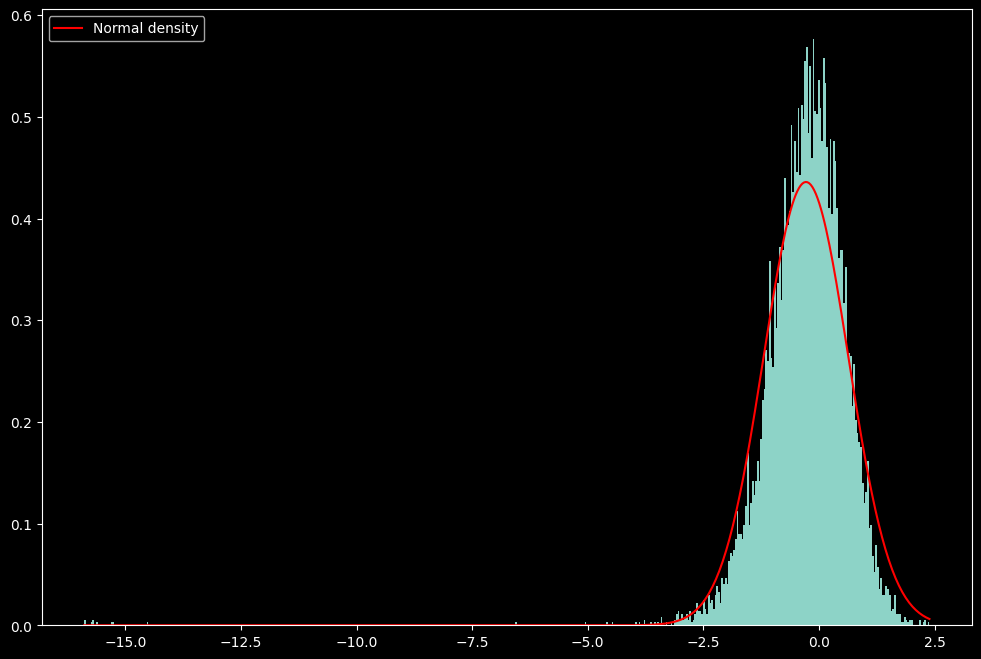

In [31]:
retSM = np.log(SM[-1, :] / S0)
x = np.linspace(retSM.min(), retSM.max(), 500)

plt.figure(figsize=(12, 8))
plt.hist(retSM, density=True, bins=500)
plt.plot(
    x, ss.norm.pdf(x, retSM.mean(), retSM.std()), color="r", label="Normal density"
)
plt.legend()
plt.show()


Setting Strike price (K) to S0 for ATM option

In [32]:
K = S0

In [33]:
call_price_q9 = merton_mc_price(SM, K, r, T, 'C')
print("European Call Price under Merton: ", call_price_q9)

European Call Price under Merton:  23.48


In [34]:
put_price_q9 = merton_mc_price(SM, K, r, T, 'P')
print("European Put Price under Merton: ", put_price_q9)

European Put Price under Merton:  22.01


## Model Validator

**Question 11) Model put-call parity**

In [40]:
# Call PUT Partity Q8) lamba 0.75

lhs = round(call_price_q8 + 100 * np.exp(-r * T), 2)
rhs = round(100 + put_price_q8, 2)

-1 <= int(lhs) - int(rhs) <= 1

print ("LHS {}, RHS {}".format(lhs, rhs))


LHS 128.17, RHS 122.01


In [36]:
# Call PUT Partity Q9) lamba 0.25

lhs = round(call_price_q9 + 100 * np.exp(-r * T), 2)
rhs = round(100 + put_price_q9, 2)

assert -1 <= int(lhs) - int(rhs) <= 1

print ("LHS {}, RHS {}".format(lhs, rhs))

LHS 122.11, RHS 122.01


**Question 12) Heston Model and Merton Model Call prices for different strikes**

In [37]:
for k in [85, 90, 95, 100, 105, 110]:
  call_price = merton_mc_price(SM, k, r, T, 'P')
  print(f"European Call Price for stike {k} under Merton: ", call_price)

European Call Price for stike 85 under Merton:  25.12
European Call Price for stike 90 under Merton:  28.37
European Call Price for stike 95 under Merton:  31.76
European Call Price for stike 100 under Merton:  35.29
European Call Price for stike 105 under Merton:  38.92
European Call Price for stike 110 under Merton:  42.65
